# WebDataset reader
In this notebook is an example of how one may combine the [webdataset](https://github.com/webdataset/webdataset) with the DALI pipeline

## Introduction
### Data Representation
Web Dataset is a dataset representation that heavily optimizes networked accessed storage performance. At its simplest, it stores the whole dataset in one tarball file, where individual samples are kept under the files with the same names but different extensions. This approach improves drive access latency a lot, since the files are kept on the drive directly next to each other, improving drive access caching on the RAM.
### Sharding
In order to improve distributed storage access and network data transfer, the webdataset employs a strategy called sharding. In this approach, the tarball holding the data is split into several smaller ones, called shards, which allows for fetching from several storage drives at once, and reduces the packet size that has to be transferred via the network.

## Usage Example
First, let's import the necessary modules and define the locations of the datasets that will be needed later.

`DALI_EXTRA_PATH` environment variable should point to the place where the data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

The `tar_dataset_paths` holds the paths to the shards that will be loaded while showing and testing the webdataset reader.

The `folder_dataset_files` holds the paths to the files unpacked from those shards and will be used to compare the webdataset reader with an already implemented file reader.

In [1]:
import nvidia.dali.fn as fn
import nvidia.dali as dali
import webdataset as wds
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random

root_path = os.path.join(os.environ["DALI_EXTRA_PATH"], "db", "webdataset")
tar_dataset_paths = [os.path.join(root_path, data_file) 
                        for data_file in ["devel-0.tar", "devel-1.tar", "devel-2.tar"]]

folder_dataset_files = glob.glob(os.path.join(root_path, "devel-[012]", "*.jpg"))

folder_dataset_files = sorted( # Sorted in order to match the data from the shards
    folder_dataset_files,
    key = lambda s: (
        s[:s.rfind('/')], # First we sort over the dataset name 
        int(s[s.rfind('/') + 1:s.find(".jpg")]) # Then we sort over the indicies of the samples
    )
) 

The function below is used to later randomize the output from the dataset. The samples are first stored in a buffer, and then they're randomly yielded in a generator and replaced by a new sample.

In [2]:
def buffered_shuffle(generator, initial_fill, seed):
    # The buffer size must be positive
    assert(initial_fill > 0)
    
    # The buffer that will hold the randomized samples=
    buffer = []
    
    # Holds a separate random lib state to avoid side effects
    random_current_state = random.getstate()
    random.seed(seed)
    random_state = random.getstate()
    random.setstate(random_current_state)
    
    try:
        while len(buffer) < initial_fill: # Fills in the random buffer
            buffer.append(next(generator))


        while True: # Selects a random sample from the buffer and then fills it back in with a new one
            
            # Holds a separate random lib state to avoid side effects
            random_current_state = random.getstate()
            random.setstate(random_state)
            idx = random.randint(0, initial_fill-1)
            random_state = random.getstate()
            random.setstate(random_current_state)

            yield buffer[idx]
            buffer[idx] = next(generator)
            
    except StopIteration: # When the generator runs out of the samples flushes our the buffer
        
        # Holds a separate random lib state to avoid side effects
        random_current_state = random.getstate()
        random.setstate(random_state)
        random.shuffle(buffer)
        random.setstate(random_current_state)

        while buffer:
            yield buffer[-1]
            buffer.pop()
            

The next function is used for padding the last batch with the last sample, in order to make it the same size as all the other ones.

In [3]:
def last_batch_padding(generator, batch_size):
    in_batch_idx = 0
    last_item = None
    try:
        while True: # Keeps track of the last sample and the sample number mod batch_size
            if in_batch_idx >= batch_size:
                in_batch_idx -= batch_size
            last_item = next(generator)
            in_batch_idx += 1
            yield last_item
    except StopIteration: # Repeats the last sample the necessary number of times
        while in_batch_idx < batch_size:
            yield last_item
            in_batch_idx += 1

The final auxilary function is used to get an infinite number of samples from a finitie size dataset.

In [4]:
def cycle_generator(dataset_generator):
    dataset = dataset_generator()
    while True:
        try:
            while True:
                yield next(dataset)
        except StopIteration: # The dataset has run out of samples, they need to be refilled
            dataset = dataset_generator()

And finally the reader.

### Keyword Arguments:

`paths`: describes the paths to the shard file/files containing the webdataset, and can be formatted as any data accepted by the `WebDataset`

`extensions`: describes the extensions containing the data to be output through the dataset. By default this is one extension fetching the data from all image formats supported by the `WebDataset`

`random_shuffle`: describes whether to shuffle the data read by the `WebDataset`

`initial_fill`: if `random_shuffle` is True describes the buffer size of the data shuffler. Set to the batch size by default.

`seed`: describes the seed for shuffling the data. Useful for getting consistent results. Set to 0 by default

`pad_last_batch`: describes whether to pad the last batch with the final sample to match the regular batch size

`read_ahead`: describes whether to prefetch the data into the memory

In [5]:
def read_webdataset(
    paths, 
    extensions=None,
    random_shuffle=False, 
    initial_fill=None, 
    seed=0,
    pad_last_batch=False,
    read_ahead=False
):
    # Parsing the input data
    if initial_fill == None:
        initial_fill = dali.pipeline.Pipeline.current().max_batch_size
    if extensions == None:
        extensions = ';'.join(["jpg", "jpeg", "img", "image", "pbm", "pgm", "png"]) # All supported image formats
    if type(extensions) == str:
        extensions = (extensions,)
        
    # The lambda for generating the samples later inside the cycle_generator
    dataset_generator = lambda: iter(
        wds.WebDataset(paths, shardshuffle=False)
        .to_tuple(*extensions)
        .map_tuple(*((
            lambda data: np.frombuffer(data, dtype=np.uint8),)
            *len(extensions)))
        )
    
    dataset = dataset_generator()
    
    if not read_ahead: # if read_ahead is False the cycling is handled by the external generator
        dataset = cycle_generator(dataset_generator)
    
    # Adding the buffered shuffling
    if random_shuffle:
        dataset = buffered_shuffle(dataset, initial_fill, seed)
        
    # Adding the batch padding
    if pad_last_batch:
        dataset = last_batch_padding(dataset, dali.pipeline.Pipeline.current().max_batch_size)
    
    # Prefetching the data
    if read_ahead:
        dataset=list(dataset)
    
    return fn.external_source(
        source=dataset,
        num_outputs=len(extensions),
        batch=False,
        cycle=read_ahead # if read_ahead is True then the cycling is handled by external source
    )

We also define a sample data augmentation function which decodes an image, applies a jitter to it and resizes it to 244x244.

In [6]:
def decode_augment(img, seed=0):
    img = fn.decoders.image(img)
    img = fn.jitter(img.gpu(), seed=seed)
    img = fn.resize(img, size = (224, 224))
    return img

## Reader features presentation
Below we define the sample webdataset pipeline with our `external_source`-based reader, that just chains the previously defined reader and augmentation function together.

In [7]:
@dali.pipeline_def(batch_size=16, num_threads=4, device_id=0)
def webdataset_pipeline(
    paths,
    random_shuffle=False, 
    initial_fill=None, 
    seed=0,
    pad_last_batch=False,
    read_ahead=False
):
    img, label = read_webdataset(paths=paths, 
                                 extensions=("jpg", "cls"),
                                 random_shuffle=random_shuffle,
                                 initial_fill=initial_fill,
                                 seed=seed,
                                 pad_last_batch=pad_last_batch,
                                 read_ahead=read_ahead)
    return decode_augment(img, seed=seed), label

The pipeline can then be build with the desired arguments passed through to the reader

In [8]:
pipeline = webdataset_pipeline(
    tar_dataset_paths,   # Paths for the sharded dataset
    random_shuffle=True, # Random buffered shuffling on
    pad_last_batch=True, # Last batch is filled to the full size
    read_ahead=True)     # All the data is preloaded into the memory
pipeline.build()

And executed, printing the example image using matplotlib

1


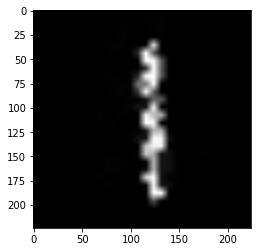

In [9]:
img, c = pipeline.run()
img = img.as_cpu()
print(int(bytes(c.as_array()[0]))) # Conversion from an array of bytes back to bytes and then to int
plt.imshow(img.as_array()[0])
plt.show()

## Checking consistency
Here we will check if the custom pipeline for the webdataset matches another one already implemented.

First let's define the pipeline to compare against. This is the same pipeline as the one for the webdataset, but instead uses the `fn.readers.file` reader.

In [10]:
@dali.pipeline_def(batch_size=16, num_threads=4, device_id=0)
def file_pipeline(files):
    img, _ = fn.readers.file(files=files)
    return decode_augment(img)

Then let's instantiate and build both pipelines

In [11]:
webdataset_pipeline_instance = webdataset_pipeline(tar_dataset_paths)
webdataset_pipeline_instance.build()
file_pipeline_instance = file_pipeline(folder_dataset_files)
file_pipeline_instance.build()

And run the comparison loop.

In [12]:
# The number of batches to sample between the two pipelines
num_batches = 1000

for _ in range(num_batches):
    webdataset_pipeline_threw_exception = False
    file_pipeline_threw_exception = False
    
    # Try running the webdataset pipeline and check if it has run out of the samples
    try:
        web_img, _ = webdataset_pipeline_instance.run()
    except StopIteration:
        webdataset_pipeline_threw_exception = True
    
    # Try running the file pipeline and check if it has run out of the samples
    try:
        (file_img,) = file_pipeline_instance.run()
    except StopIteration:
        file_pipeline_threw_exception = True
    
    # In case of different number of batches
    if webdataset_pipeline_threw_exception != file_pipeline_threw_exception:
        print("Found a difference between the readers!")
        break

    web_img = web_img.as_cpu().as_array()
    file_img = file_img.as_cpu().as_array()

    # In case the pipelines give different outputs
    if (web_img != file_img).any():
        print("Found a difference between the readers!")
        break
else:
    print("No difference found!")

No difference found!
